# Aggregate the SWE/SCA HMASR to monthly time scale with and without mask (mean and median)

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


- FORCING_POST -> PPT_Post
- SD_POST -> SD_Post
- SWE_SCA_POST -> SWE_Post, SCA_Post

## Create folders

In [4]:
# Create folders
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M_mask/'

for WY in WY_list:
    print(WY)
    !mkdir {path_out}{WY}

WY1999_00
WY2000_01
WY2001_02
WY2002_03
WY2003_04
WY2004_05
WY2005_06
WY2006_07
WY2007_08
WY2008_09
WY2009_10
WY2010_11
WY2011_12
WY2012_13
WY2013_14
WY2014_15
WY2015_16
WY2016_17


In [80]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=3, memory_limit='6GB')
# client = Client()
client

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35755 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42563 Dashboard: http://127.0.0.1:35755/status,Cluster Workers: 4 Cores: 12 Memory: 24.00 GB


In [113]:
client.close()

In [82]:
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2002))]
ds_name_list = ['SWE_SCA_POST']

swe_list = []
sca_list = []
swe_mask_list = []
sca_mask_list = []

for WY in WY_list:
    print(WY)
    
    path='/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km_mask/'+WY+'/'
    ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_'+WY+'_SWE_SCA_POST.nc', parallel=True)
    ds_mask = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_'+WY+'_SWE_SCA_POST_MASK.nc', parallel=True)
    
    ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
    ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("Stats", "time", "lat", "lon")
    
    ds_mask = ds_mask.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds_mask.Day.size, freq='D'))
    ds_mask = ds_mask.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("Stats", "time", "lat", "lon")
    
    
    swe_list.append(u.spatial_average(ds.SWE_Post).load())
    sca_list.append(u.spatial_average(ds.SCA_Post).load())
    swe_mask_list.append(u.spatial_average(ds_mask.SWE_Post).load())
    sca_mask_list.append(u.spatial_average(ds_mask.SCA_Post).load())

WY1999_00
WY2000_01
WY2001_02


In [84]:
swe_concat = xr.concat(swe_list, dim='time')
sca_concat = xr.concat(sca_list, dim='time')
swe_mask_concat = xr.concat(swe_mask_list, dim='time')
sca_mask_concat = xr.concat(sca_mask_list, dim='time')

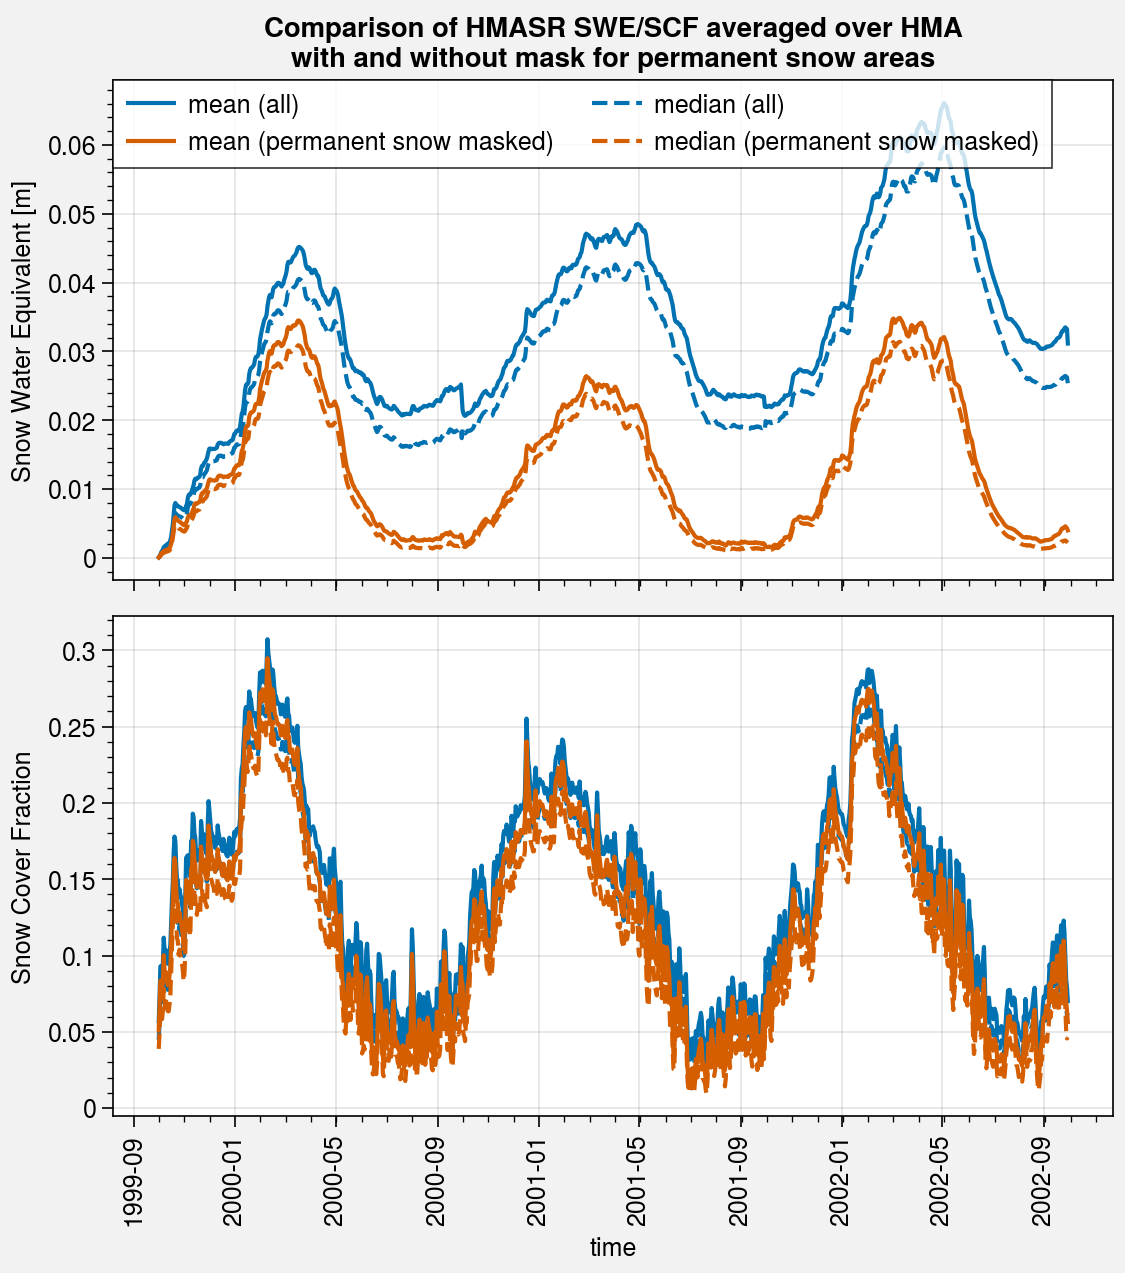

In [111]:
fig, axs = plot.subplots(nrows=2, axwidth=5, aspect=2, sharey=0)

# SWE
ax = axs[0]

ax.plot(swe_concat.isel(Stats=0), label='mean (all)')
ax.plot(swe_concat.isel(Stats=1), label='median (all)', color='C0', linestyle='--')

ax.plot(swe_mask_concat.isel(Stats=0), label='mean (permanent snow masked)')
ax.plot(swe_mask_concat.isel(Stats=1), label='median (permanent snow masked)', color='C1', linestyle='--')

ax.legend(ncols=2, loc='ul')

ax.format(
    ylabel='Snow Water Equivalent [m]'
)

# SCF
ax = axs[1]

ax.plot(sca_concat.isel(Stats=0), label='mean (all)')
ax.plot(sca_concat.isel(Stats=1), label='median (all)', color='C0', linestyle='--')

ax.plot(sca_mask_concat.isel(Stats=0), label='mean (permanent snow masked)')
ax.plot(sca_mask_concat.isel(Stats=1), label='median (permanent snow masked)', color='C1', linestyle='--')

ax.format(
    ylabel='Snow Cover Fraction'
)


axs.format(
    suptitle='Comparison of HMASR SWE/SCF averaged over HMA\nwith and without mask for permanent snow areas'
)

fig.save('HMASR_SWE_SCF_mask_1999-2002.jpg')

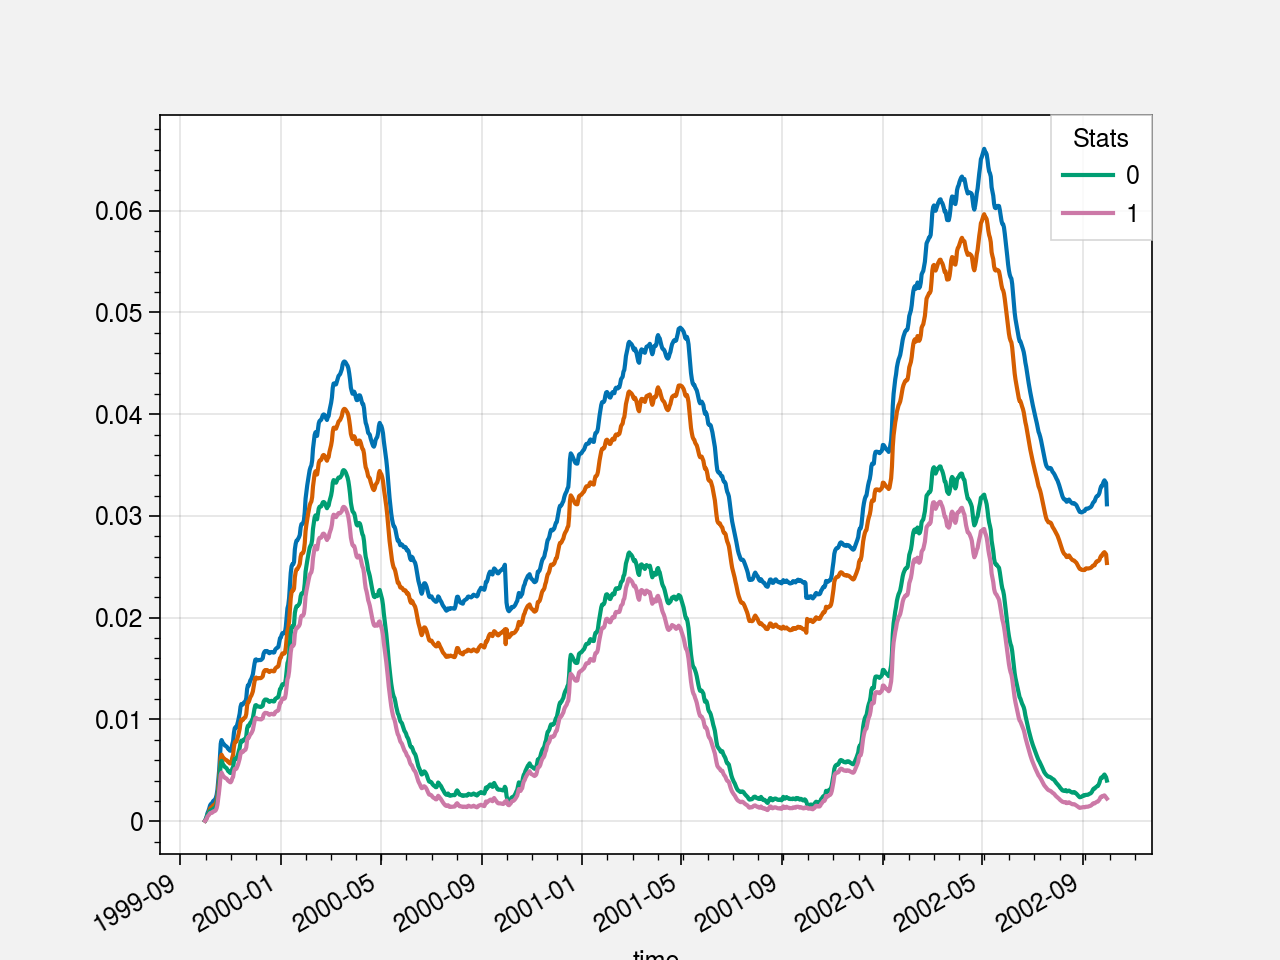

In [85]:
swe_concat.plot(hue='Stats')
swe_mask_concat.plot(hue='Stats')

In [49]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km_mask/WY1999_00/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_SWE_SCA_POST.nc')
ds

,Array,Chunk
Bytes,2.32 MB,2.93 kB
Shape,"(366, 2, 44, 18)","(366, 2, 1, 1)"
Count,5955 Tasks,792 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.32 MB,2.93 kB
Shape,"(366, 2, 44, 18)","(366, 2, 1, 1)"
Count,5955 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [50]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km_mask/WY1999_00/'
ds_mask = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_SWE_SCA_POST_MASK.nc')
ds_mask

,Array,Chunk
Bytes,2.32 MB,2.93 kB
Shape,"(366, 2, 44, 18)","(366, 2, 1, 1)"
Count,5955 Tasks,792 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.32 MB,2.93 kB
Shape,"(366, 2, 44, 18)","(366, 2, 1, 1)"
Count,5955 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [56]:
swe = u.spatial_average(ds.SWE_Post).load()
sca = u.spatial_average(ds.SCA_Post).load()
swe_mask = u.spatial_average(ds_mask.SWE_Post).load()
sca_mask = u.spatial_average(ds_mask.SCA_Post).load()

In [64]:
swe.Stats

<xarray.DataArray 'Stats' (Stats: 2)>
array([0, 1])
Dimensions without coordinates: Stats

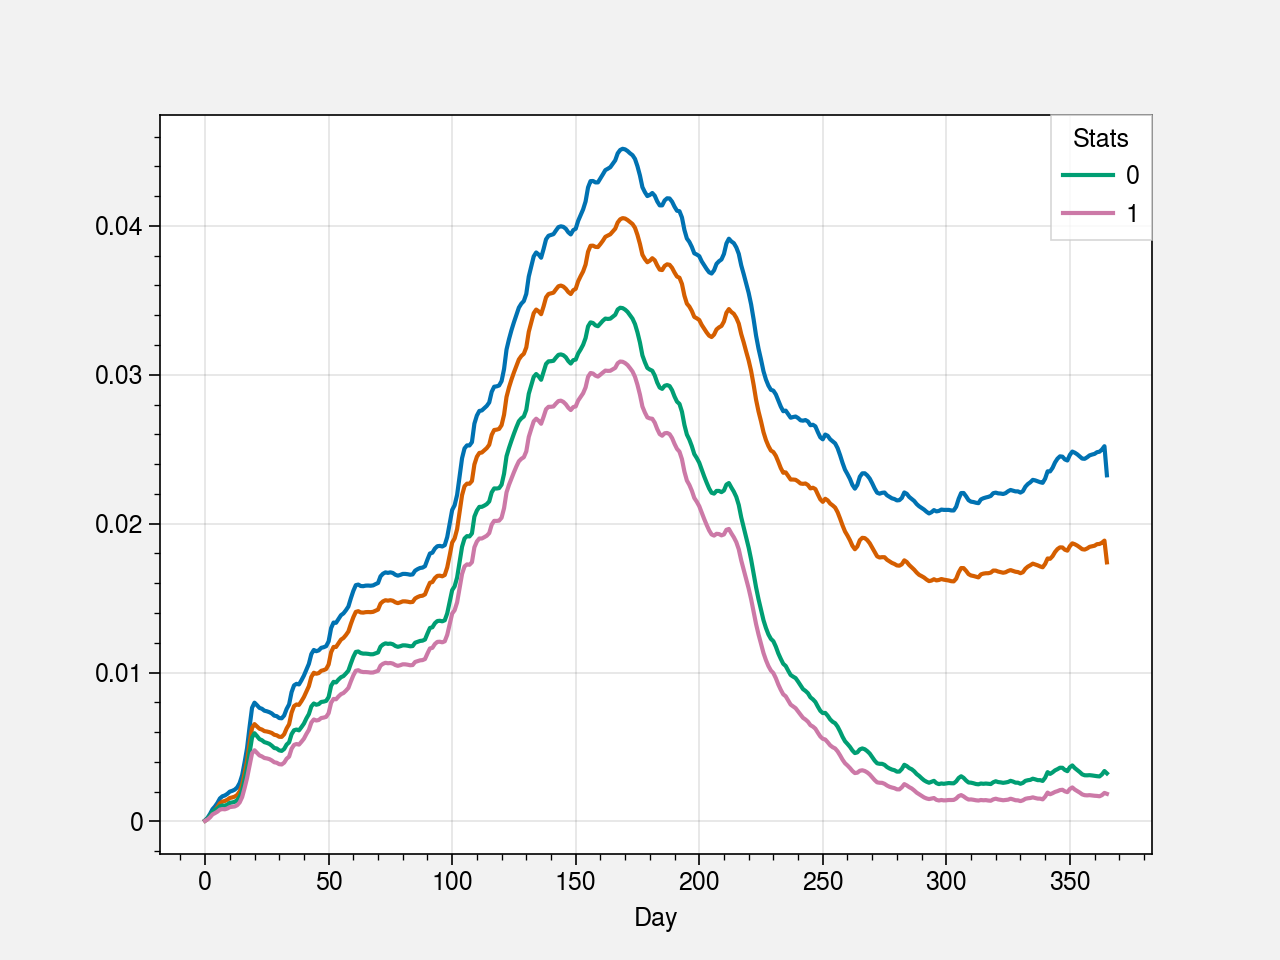

In [66]:
swe.plot(hue='Stats')
swe_mask.plot(hue='Stats')

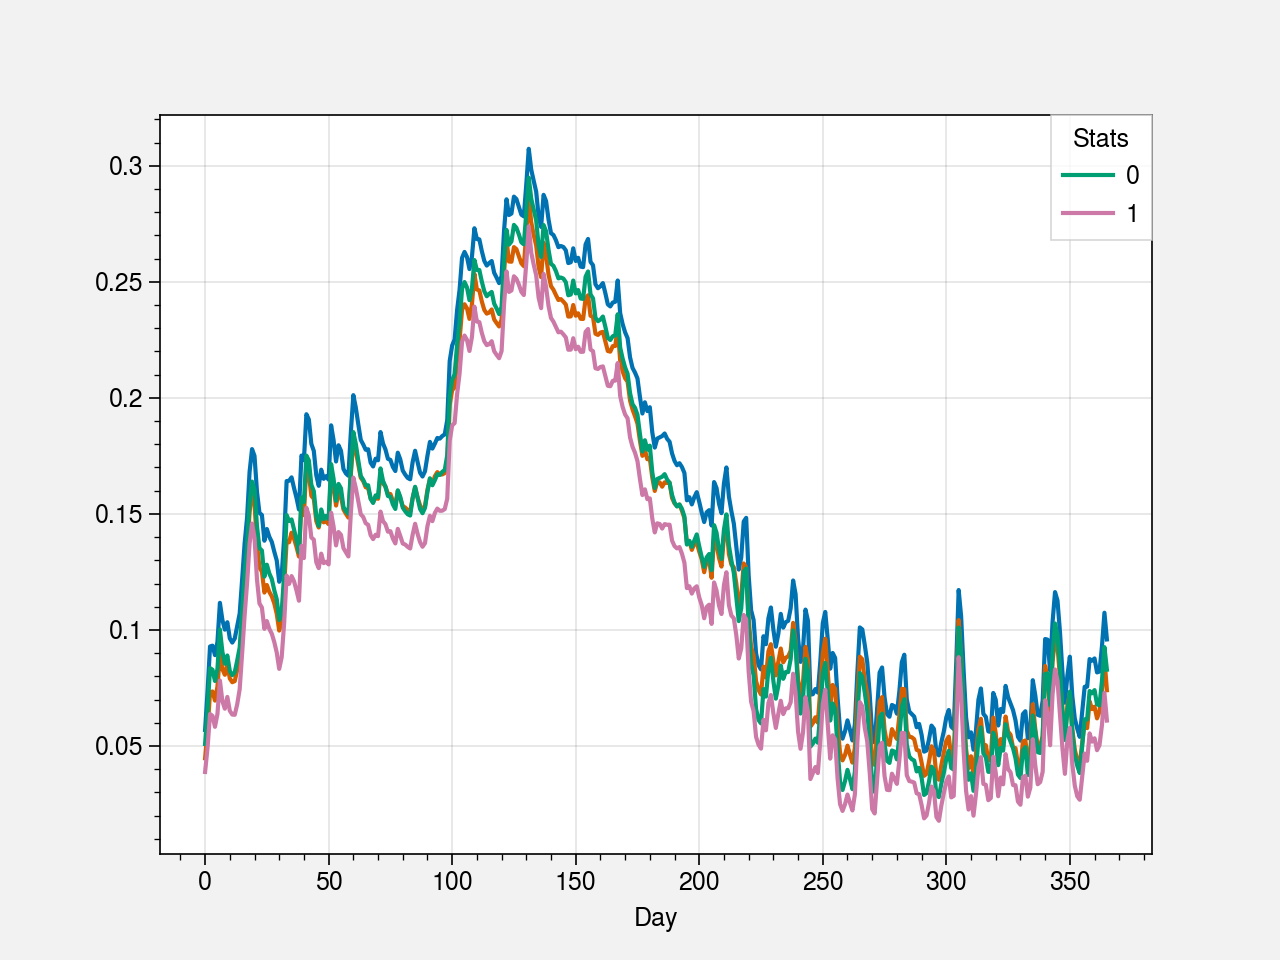

In [67]:
sca.plot(hue='Stats')
sca_mask.plot(hue='Stats')

In [11]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True)
ds


<xarray.Dataset>
Dimensions:                 (Latitude: 4050, Longitude: 9900, Water_Year: 18)
Coordinates:
  * Water_Year              (Water_Year) float64 2e+03 2.001e+03 ... 2.017e+03
  * Latitude                (Latitude) float64 27.0 27.01 27.01 ... 44.99 45.0
  * Longitude               (Longitude) float64 61.0 61.01 61.01 ... 105.0 105.0
Data variables:
    Classification_mask     (Water_Year, Longitude, Latitude) float32 dask.array<chunksize=(18, 225, 225), meta=np.ndarray>
    Non_seasonal_snow_mask  (Longitude, Latitude) float32 dask.array<chunksize=(225, 225), meta=np.ndarray>

In [11]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True)
ds


<xarray.Dataset>
Dimensions:                 (Latitude: 4050, Longitude: 9900, Water_Year: 18)
Coordinates:
  * Water_Year              (Water_Year) float64 2e+03 2.001e+03 ... 2.017e+03
  * Latitude                (Latitude) float64 27.0 27.01 27.01 ... 44.99 45.0
  * Longitude               (Longitude) float64 61.0 61.01 61.01 ... 105.0 105.0
Data variables:
    Classification_mask     (Water_Year, Longitude, Latitude) float32 dask.array<chunksize=(18, 225, 225), meta=np.ndarray>
    Non_seasonal_snow_mask  (Longitude, Latitude) float32 dask.array<chunksize=(225, 225), meta=np.ndarray>

In [11]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True)
ds


<xarray.Dataset>
Dimensions:                 (Latitude: 4050, Longitude: 9900, Water_Year: 18)
Coordinates:
  * Water_Year              (Water_Year) float64 2e+03 2.001e+03 ... 2.017e+03
  * Latitude                (Latitude) float64 27.0 27.01 27.01 ... 44.99 45.0
  * Longitude               (Longitude) float64 61.0 61.01 61.01 ... 105.0 105.0
Data variables:
    Classification_mask     (Water_Year, Longitude, Latitude) float32 dask.array<chunksize=(18, 225, 225), meta=np.ndarray>
    Non_seasonal_snow_mask  (Longitude, Latitude) float32 dask.array<chunksize=(225, 225), meta=np.ndarray>

In [12]:
mask = ds.Non_seasonal_snow_mask
mask

<xarray.DataArray 'Non_seasonal_snow_mask' (Longitude: 9900, Latitude: 4050)>
dask.array<concatenate, shape=(9900, 4050), dtype=float32, chunksize=(225, 225), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float64 27.0 27.01 27.01 27.02 ... 44.99 44.99 45.0
  * Longitude  (Longitude) float64 61.0 61.01 61.01 61.02 ... 105.0 105.0 105.0
Attributes:
    Units:    [-]

In [33]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
ds = xr.open_dataset(path+'HMA_SR_D_v01_N28_0E86_0_agg_16_WY1999_00_SD_POST.nc')
ds


<xarray.Dataset>
Dimensions:    (Day: 366, Latitude: 225, Longitude: 225, Stats: 5)
Coordinates:
  * Latitude   (Latitude) float32 28.997778 28.993334 ... 28.006739 28.002295
  * Longitude  (Longitude) float32 86.00222 86.00667 ... 86.99411 86.99856
Dimensions without coordinates: Day, Stats
Data variables:
    SD_Post    (Day, Stats, Longitude, Latitude) float32 ...

In [39]:
mask = xr.open_dataset(path+'HMA_SR_D_v01_N28_0E86_0_agg_16_WY1999_00_MASK.nc')
mask

<xarray.Dataset>
Dimensions:                 (Latitude: 225, Longitude: 225, Water_Year: 18)
Coordinates:
  * Longitude               (Longitude) float32 86.00222 86.00667 ... 86.99856
  * Latitude                (Latitude) float32 28.997778 28.993334 ... 28.002295
  * Water_Year              (Water_Year) float64 2e+03 2.001e+03 ... 2.017e+03
Data variables:
    Classification_mask     (Water_Year, Longitude, Latitude) float32 ...
    Non_seasonal_snow_mask  (Longitude, Latitude) float32 ...

In [42]:
mask = mask.Non_seasonal_snow_mask

In [47]:
(ds.SD_Post.isel(Stats=0).max('Day')).where(mask == 0).mean()

<xarray.DataArray 'SD_Post' ()>
array(0.19341119, dtype=float32)

In [45]:
ds.SD_Post.isel(Stats=0).max('Day').coarsen(Latitude=225, Longitude=225).mean()

<xarray.DataArray (Longitude: 1, Latitude: 1)>
array([[1.4114934]], dtype=float32)
Coordinates:
  * Latitude   (Latitude) float32 28.500034
  * Longitude  (Longitude) float32 86.50038

In [46]:
(ds.SD_Post.isel(Stats=0).max('Day')).where(mask == 0).coarsen(Latitude=225, Longitude=225).mean()

<xarray.DataArray (Longitude: 1, Latitude: 1)>
array([[0.19341119]], dtype=float32)
Coordinates:
  * Latitude   (Latitude) float32 28.500034
  * Longitude  (Longitude) float32 86.50038

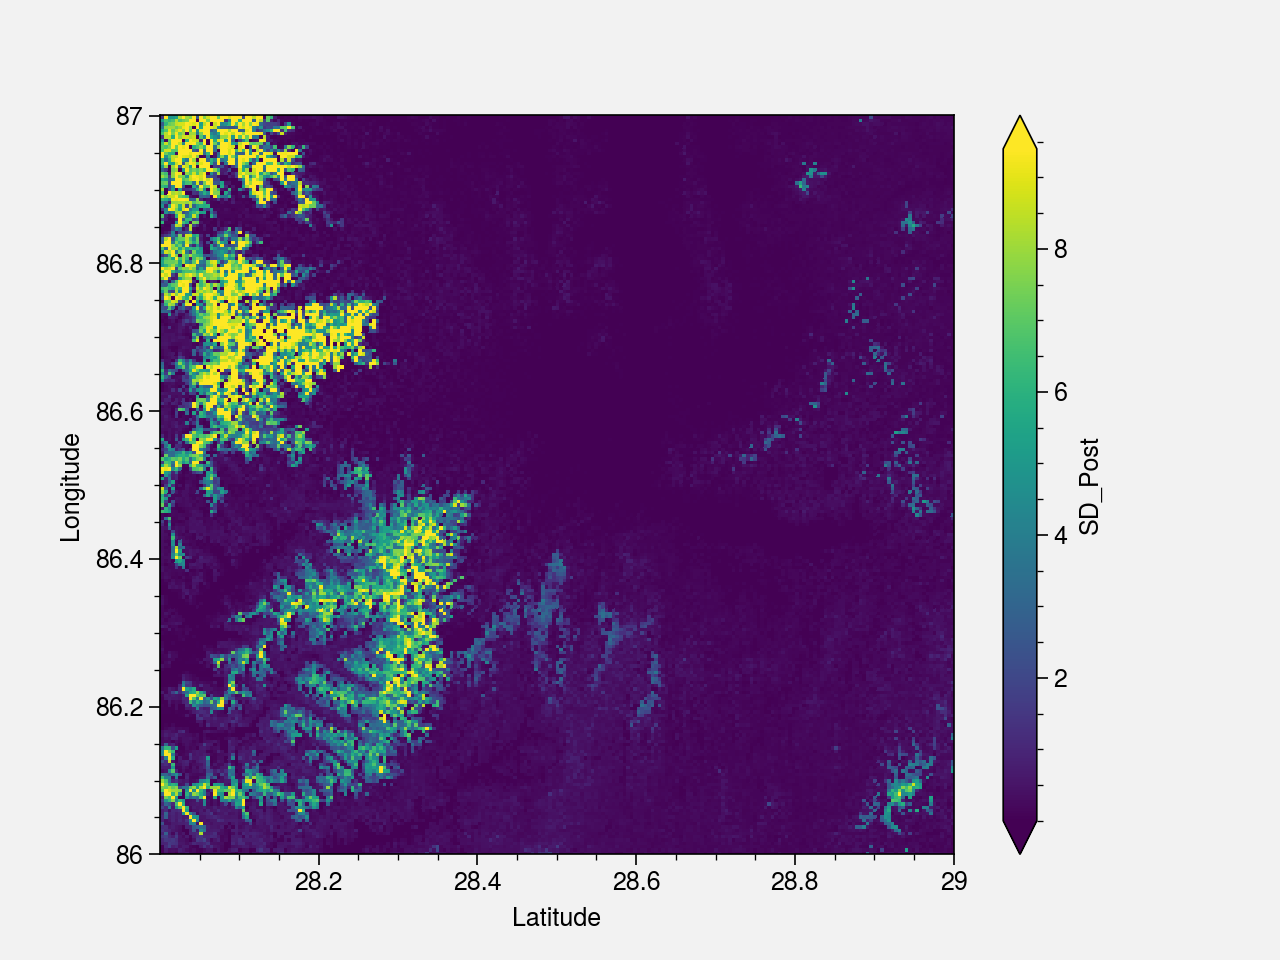

In [38]:
ds.SD_Post.isel(Stats=0).max('Day').plot(robust=True)

In [19]:
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_SD_POST.nc', parallel=True)
ds


,Array,Chunk
Bytes,293.50 GB,370.57 MB
Shape,"(366, 5, 9900, 4050)","(366, 5, 225, 225)"
Count,5955 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [27]:
ds.isel(Stats=[0,2])

,Array,Chunk
Bytes,117.40 GB,148.23 MB
Shape,"(366, 2, 9900, 4050)","(366, 2, 225, 225)"
Count,6747 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [20]:
sd = ds.SD_Post.isel(Day=0, Stats=0).sel(Longitude=slice(85, 90), Latitude=slice(28, 30)).load()

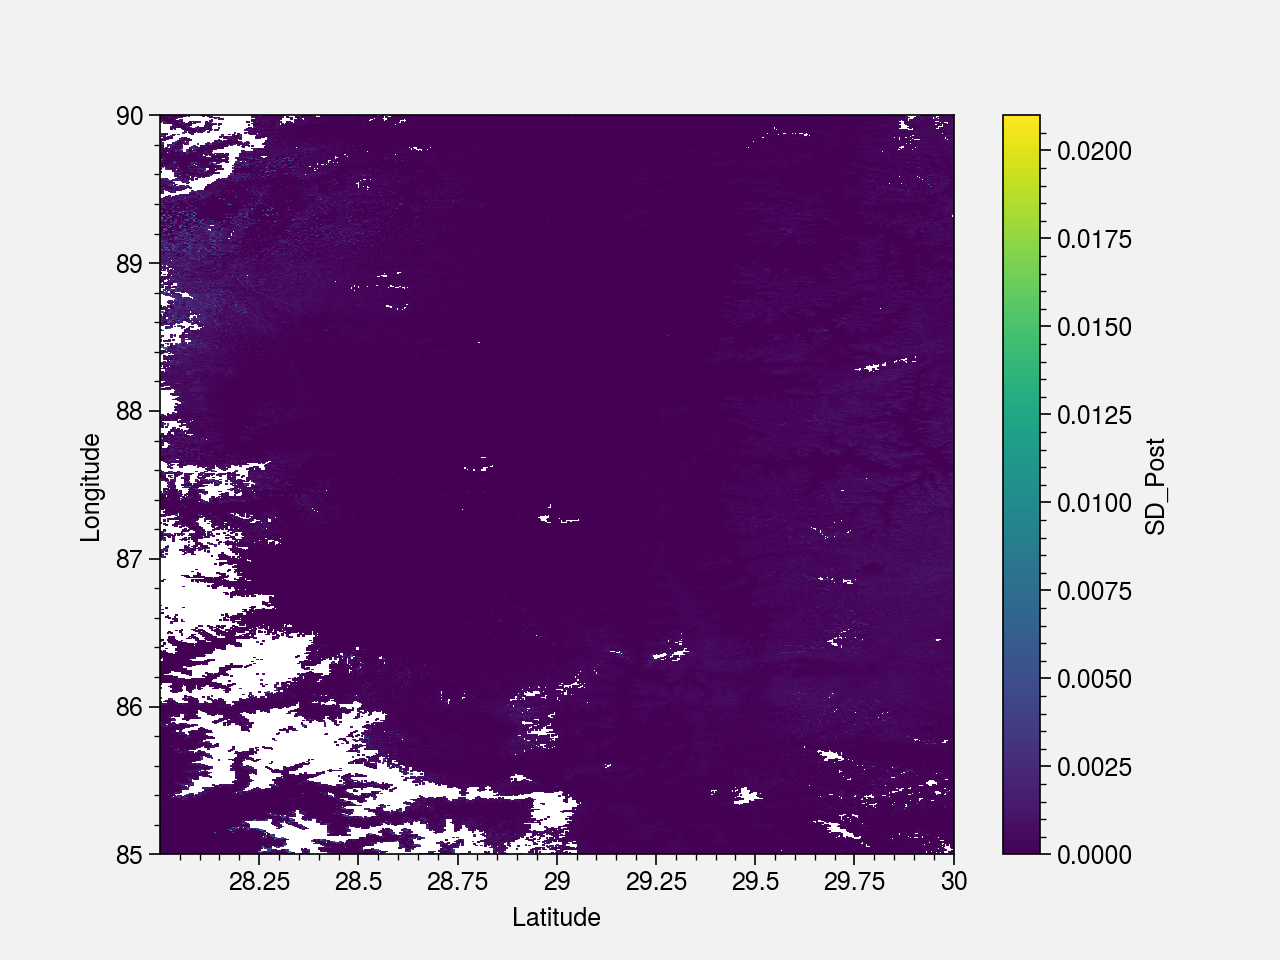

In [25]:
sd.where(mask_subset == 0).plot()

In [16]:
mask_subset = mask.sel(Longitude=slice(85, 90), Latitude=slice(28, 30)).load()

In [30]:
mask_subset.mean()

<xarray.DataArray 'Non_seasonal_snow_mask' (Longitude: 1125, Latitude: 450)>
array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)
Coordinates:
  * Latitude   (Latitude) float64 28.0 28.01 28.01 28.02 ... 29.99 29.99 30.0
  * Longitude  (Longitude) float64 85.0 85.01 85.01 85.02 ... 89.99 89.99 90.0
Attributes:
    Units:    [-]

In [31]:
mask_subset.mean()

<xarray.DataArray 'Non_seasonal_snow_mask' ()>
array(0.09469037, dtype=float32)

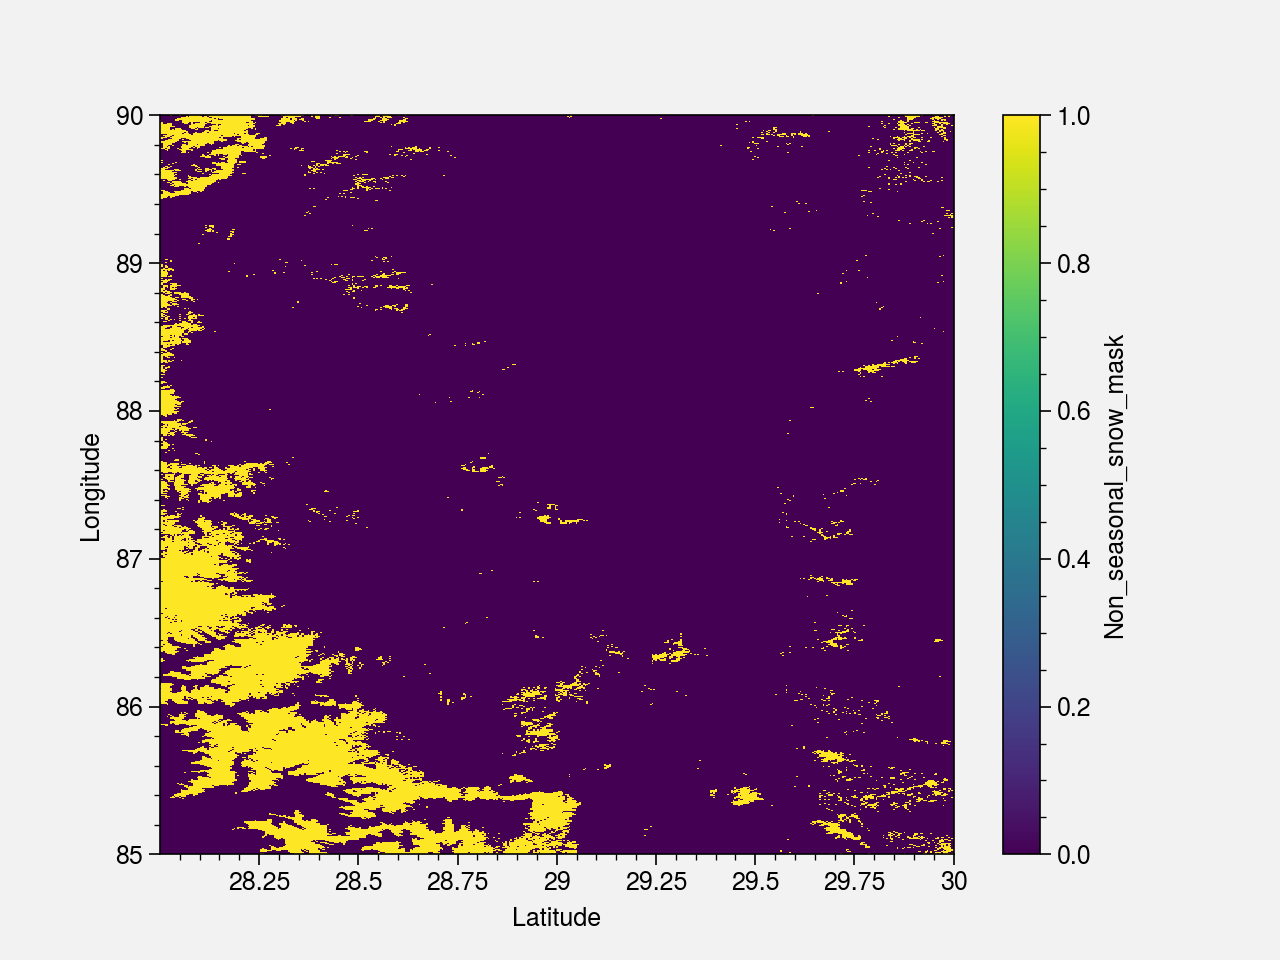

In [18]:
mask_subset.plot()

In [28]:
s = 'HMA_SR_D_v01_N27_0E66_0_agg_16_WY1999_00_SWE_SCA_POST.nc'

In [29]:
s.replace('SWE_SCA_POST', 'MASK')

'HMA_SR_D_v01_N27_0E66_0_agg_16_WY1999_00_MASK.nc'

In [83]:
from os import listdir

WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
# ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']
ds_name_list = ['SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
    path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M_mask/'+WY+'/'
    
    for ds_name in ds_name_list:
        print(ds_name)
        list_files = [f for f in listdir(path) if ds_name in f]
        
        for file in list_files:
            ds = xr.open_dataset(path+file)
            mask = xr.open_dataset(path+file.replace(ds_name, 'MASK'))
            if ds_name not in ['FORCING_POST']:
                ds = ds.isel(Stats=[0,2]) # Select ensemble mean (0) and median (2)
            ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
            ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("Stats", "time", "lat", "lon")
            
            # Resample to monthly time scale
            ds_monthly = ds.resample(time='1M').mean()
            
            # Mask and non mask
            
            
            # Change frequency 'D' to 'M' in file name
            file_list = list(file.replace('agg_16', '5km'))
            file_list[7] = 'M'
            file_out = ''.join(file_list)
            
            ds_monthly.to_netcdf(path_out+file_out)

WY1999_00
SD_POST


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


SWE_SCA_POST
WY2000_01
SD_POST
SWE_SCA_POST
WY2001_02
SD_POST
SWE_SCA_POST
WY2002_03
SD_POST
SWE_SCA_POST
WY2003_04
SD_POST
SWE_SCA_POST
WY2004_05
SD_POST
SWE_SCA_POST
WY2005_06
SD_POST
SWE_SCA_POST
WY2006_07
SD_POST
SWE_SCA_POST
WY2007_08
SD_POST
SWE_SCA_POST
WY2008_09
SD_POST
SWE_SCA_POST
WY2009_10
SD_POST
SWE_SCA_POST
WY2010_11
SD_POST
SWE_SCA_POST
WY2011_12
SD_POST
SWE_SCA_POST
WY2012_13
SD_POST
SWE_SCA_POST
WY2013_14
SD_POST
SWE_SCA_POST
WY2014_15
SD_POST
SWE_SCA_POST
WY2015_16
SD_POST
SWE_SCA_POST
WY2016_17
SD_POST
SWE_SCA_POST


### Old version for testing one by one

In [2]:
# WY = 'WY1999_00'
WY = 'WY2001_02'

In [3]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M/'+WY+'/'

In [4]:
from os import listdir
# list_files = [f for f in listdir(path) if 'SWE_SCA_POST' in f]
list_files = [f for f in listdir(path) if 'SWE_SCA_POST' in f]
list_files[:10]

['HMA_SR_D_v01_N27_0E100_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E66_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E67_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E83_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E84_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E85_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E86_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E87_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E88_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E89_0_agg_16_WY2001_02_SWE_SCA_POST.nc']

In [11]:
ds = xr.open_dataset(path+list_files[0]).isel(Stats=0)
ds = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))
ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
ds

<xarray.Dataset>
Dimensions:   (lat: 225, lon: 225, time: 365)
Coordinates:
  * lat       (lat) float32 27.997778 27.993334 27.98889 ... 27.006739 27.002295
  * lon       (lon) float32 100.00222 100.00667 ... 100.99411 100.99856
  * time      (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2000-09-29
Data variables:
    SWE_Post  (time, lat, lon) float32 ...
    SCA_Post  (time, lat, lon) float32 ...

In [39]:
%%time
mon = ds.resample(time='1M').mean()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CPU times: user 10 s, sys: 159 ms, total: 10.2 s
Wall time: 9.75 s


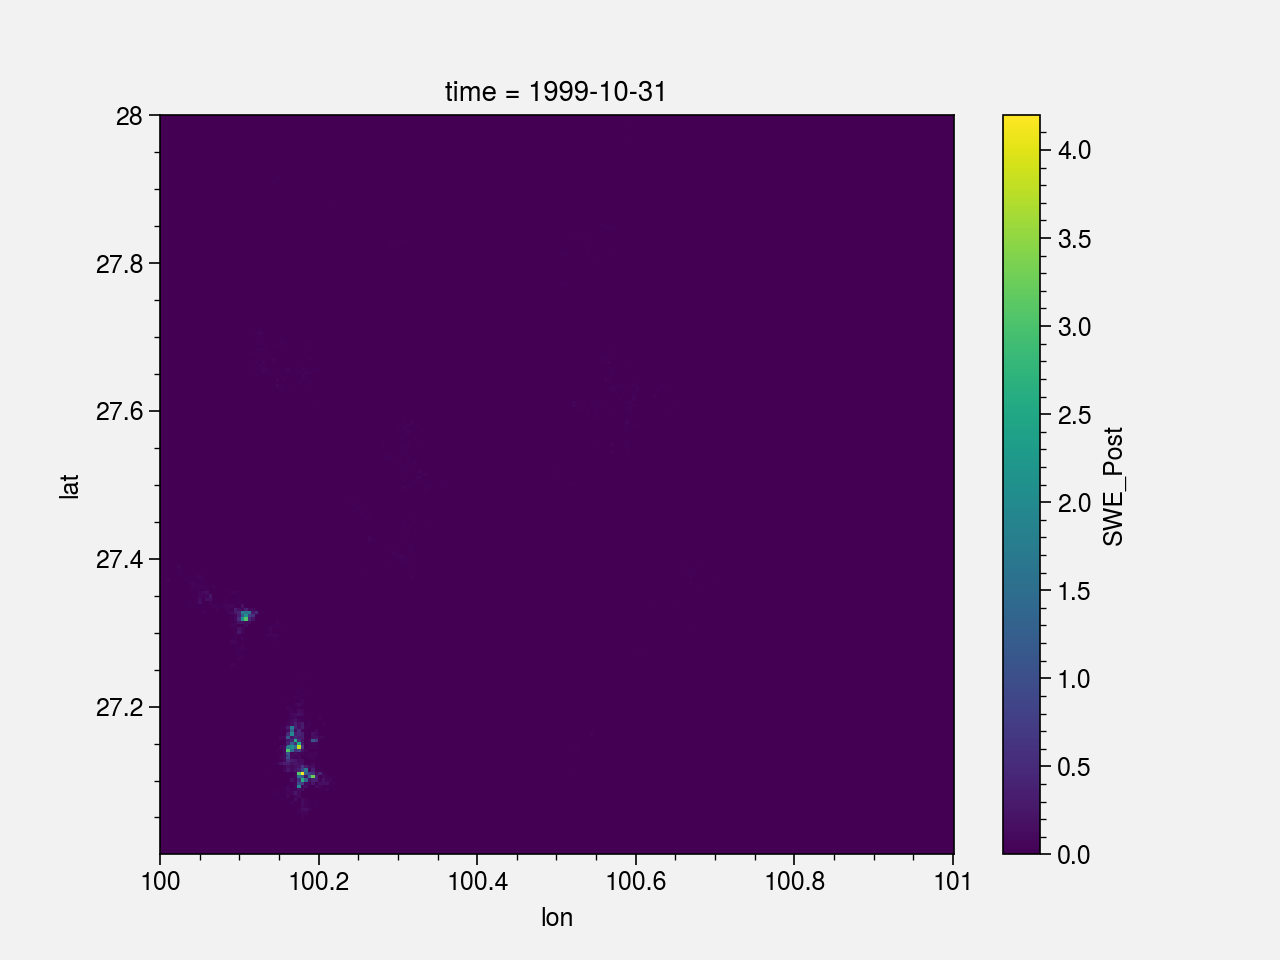

In [24]:
mon.SWE_Post[0].plot()

## Combine files to a single file
Add also dates and rename/reorganize dimensions

In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:33285 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.00 GB


In [96]:
client.close()

In [3]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M/'
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M_combined/'

WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
# ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']
ds_name_list = ['SD_POST',  'SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    for ds_name in ds_name_list:
        print(ds_name)
        ds = xr.open_mfdataset(path+WY+'/*'+ds_name+'*', parallel=True)
        ds.to_netcdf(path_out+'HMA_SR_M_v01_all_5km_'+WY+'_'+ds_name+'.nc')

WY1999_00
SD_POST
SWE_SCA_POST
WY2000_01
SD_POST
SWE_SCA_POST
WY2001_02
SD_POST
SWE_SCA_POST
WY2002_03
SD_POST
SWE_SCA_POST
WY2003_04
SD_POST
SWE_SCA_POST
WY2004_05
SD_POST
SWE_SCA_POST
WY2005_06
SD_POST
SWE_SCA_POST
WY2006_07
SD_POST
SWE_SCA_POST
WY2007_08
SD_POST
SWE_SCA_POST
WY2008_09
SD_POST
SWE_SCA_POST
WY2009_10
SD_POST
SWE_SCA_POST
WY2010_11
SD_POST
SWE_SCA_POST
WY2011_12
SD_POST
SWE_SCA_POST
WY2012_13
SD_POST
SWE_SCA_POST
WY2013_14
SD_POST
SWE_SCA_POST
WY2014_15
SD_POST
SWE_SCA_POST
WY2015_16
SD_POST
SWE_SCA_POST
WY2016_17
SD_POST
SWE_SCA_POST


In [26]:
%%time
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'
# WY = 'WY1999_00'
WY = 'WY2000_01'
ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']

ds = xr.open_mfdataset(path+WY+'/*'+ds_name_list[1]+'*', parallel=True)
ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')

CPU times: user 3.27 s, sys: 795 ms, total: 4.07 s
Wall time: 5.94 s


,Array,Chunk
Bytes,1.16 MB,1.46 kB
Shape,"(365, 18, 44)","(365, 1, 1)"
Count,6744 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [27]:
ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')

In [28]:
test = xr.open_dataset(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')
test

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 365)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2001-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 ...

In [ ]:
ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))

In [ ]:
ds_test = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))
swe = ds_test.SWE_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
scf = ds_test.SCA_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")